In [1]:
import torch
import torchvision
import torchvision.transforms as T
import random
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

device = torch.device("cuda:0")

In [3]:
from skimage.filters import gaussian

def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled
    
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

def post_process_output(q_img, cos_img, sin_img, width_img):
    """
    Post-process the raw output of the GG-CNN, convert to numpy arrays, apply filtering.
    :param q_img: Q output of GG-CNN (as torch Tensors)
    :param cos_img: cos output of GG-CNN
    :param sin_img: sin output of GG-CNN
    :param width_img: Width output of GG-CNN
    :return: Filtered Q output, Filtered Angle output, Filtered Width output
    """
    q_img = q_img.detach().cpu().numpy().squeeze()
    ang_img = (torch.atan2(sin_img, cos_img) / 2.0).detach().cpu().numpy().squeeze()
    width_img = width_img.detach().cpu().numpy().squeeze() * 150.0

    q_img = gaussian(q_img, 2.0, preserve_range=True)
    ang_img = gaussian(ang_img, 2.0, preserve_range=True)
    width_img = gaussian(width_img, 1.0, preserve_range=True)

    return q_img, ang_img, width_img

In [4]:
from utils.dataset_processing import evaluation, grasp

In [5]:
net = torch.load('/media/will/research/mtgrasp/output/models/200403_1837_RGBretrainClass/epoch_28_iou_0.93_class_0.35')
for param in net.parameters():
    param.requires_grad = False

In [6]:
from utils.data.cornell_class import CornellCocoDataset
dset = CornellCocoDataset('/media/will/research/cornell/images', json='annotations/coco.json', 
                          include_depth=False, include_rgb=True, train=False, transform=T.Compose([T.ToTensor()]))
categories = dset.catnms
print(categories)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
['apple', 'asparagus', 'bag', 'ball', 'banana', 'baseball hat', 'book', 'bowl', 'box', 'cable', 'calculator', 'camera', 'can', 'can opener', 'candle', 'capo', 'clip', 'corkscrew', 'courgette', 'cup', 'deodorant', 'flip flop', 'floss', 'frisbee', 'glasses', 'glasses case', 'goggles', 'hairbrush', 'headphones', 'kiwi', 'lemon', 'lightbulb', 'lime', 'lock', 'lollipop', 'mango', 'masher', 'mouse', 'mouthguard', 'mug', 'nail polish', 'onion', 'orange', 'peeler', 'pen', 'pepper', 'pez', 'phone', 'plum', 'potato', 'pour bottle', 'razor', 'remote', 'ribbon', 'rolling pin', 'scissors', 'screwdriver', 'shoe', 'soap', 'spatula', 'spice', 'sponge', 'spoon', 'spray bottle', 'squirt bottle', 'stapler', 'straw hat', 'string', 'sweet', 'tape', 'tennis balls', 'thread', 'toilet brush', 'tomato', 'toothbrush', 'toothpaste', 'torch', 'umbrella', 'whisk', 'wiper']


In [7]:
data = torch.utils.data.DataLoader(dset, batch_size=1, shuffle=False)

In [8]:
images = []
classes = []
grasps = []
for i in data:
    images.append(i[0].to(device))
    classes.append(i[1]['category_id'].to(device))
    grasps.append(tuple(x.to(device) for x in i[2]))

In [9]:
category = []
for i in classes:
    category.append(categories[i])

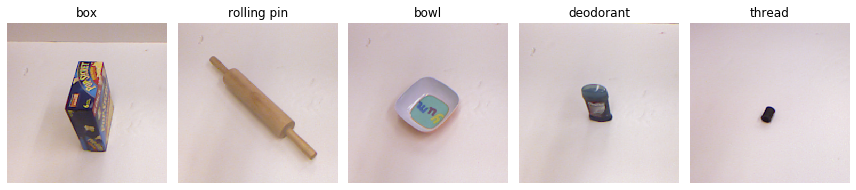

In [10]:
plt.figure(figsize=(12,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(images[i].squeeze(0).cpu().numpy().transpose(1,2,0))
    plt.title(category[i])
    plt.axis('off')
plt.gcf().tight_layout()

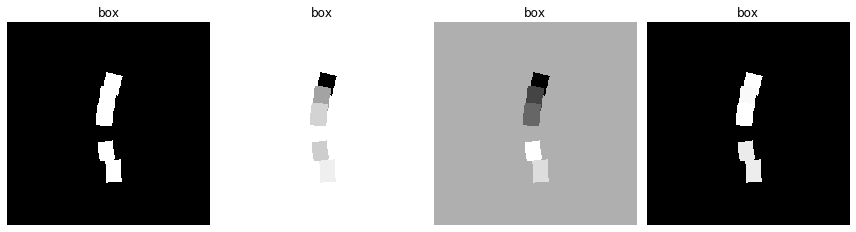

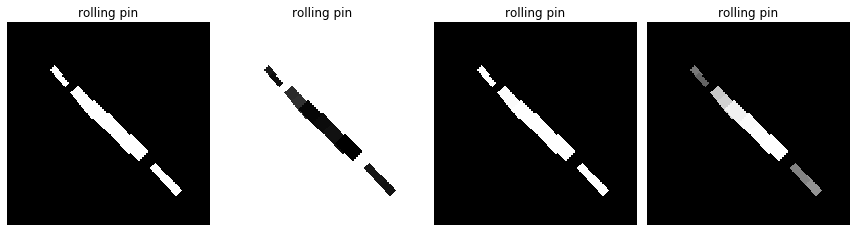

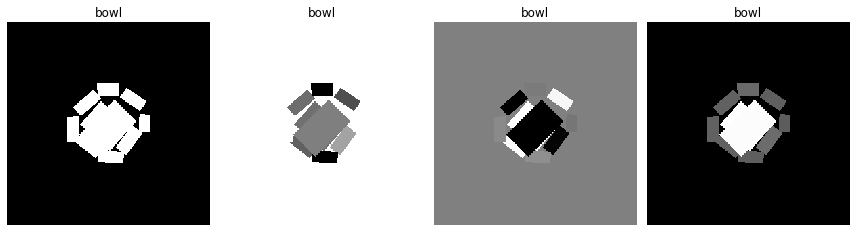

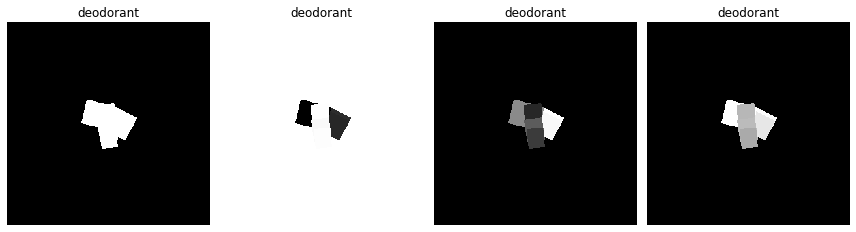

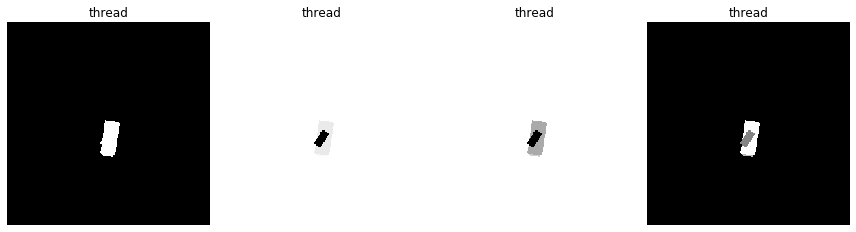

In [11]:
for j in range(5):
    plt.figure(figsize=(12,6))
    for i in range(4):
        plt.subplot(1,4,i+1)
        plt.imshow(grasps[j][i].squeeze().cpu().numpy())
        plt.title(category[j])
        plt.axis('off')
    plt.gcf().tight_layout()

In [12]:
def saliency_map(X, target, y, model, loss='grasp'):
    model.eval()
    X.requires_grad_()
    
    lossd = model.compute_loss(X, target, y)
    
    grasploss = lossd['loss']['grasp']
    classloss = lossd['loss']['class']
    
    if loss == 'grasp':
        grasploss.backward()
    elif loss == 'class':
        classloss.backward()
    elif loss == 'combined':
        grasploss.backward(retain_graph=True)
        classloss.backward()
    else:
        print('No Loss implemented')
    
    saliency = torch.abs(X.grad)
    saliency, _ = torch.max(saliency, 1)
    saliency = saliency.data
    
    return saliency

In [13]:
from utils.dataset_processing.grasp import GraspRectangles, detect_grasps

In [14]:
def plot_output(img, grasp_q_img, grasp_angle_img, no_grasps=1, grasp_width_img=None, classification=None):
    """
    Plot the output of a GG-CNN
    :param rgb_img: RGB Image
    :param grasp_q_img: Q output of GG-CNN
    :param grasp_angle_img: Angle output of GG-CNN
    :param no_grasps: Maximum number of grasps to plot
    :param grasp_width_img: (optional) Width output of GG-CNN
    :return:
    """
    gs = detect_grasps(grasp_q_img, grasp_angle_img, width_img=grasp_width_img, no_grasps=no_grasps)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(2, 2, 1)
    ax.imshow(img)
    for g in gs:
        g.plot(ax)
    if classification is not None:
        ax.set_title('Label: ' + classification)
    ax.axis('off')

    ax = fig.add_subplot(2, 2, 3)
    plot = ax.imshow(grasp_q_img, cmap='jet', vmin=0, vmax=1)
    ax.set_title('Q')
    ax.axis('off')
    plt.colorbar(plot)

    ax = fig.add_subplot(2, 2, 4)
    plot = ax.imshow(grasp_angle_img, cmap='hsv', vmin=-np.pi / 2, vmax=np.pi / 2)
    ax.set_title('Angle')
    ax.axis('off')
    plt.colorbar(plot)

    plt.show()
    #return fig

In [15]:
def show_saliency_maps(X, target, y, model):
    pos, cos, sin, width, pred = model(X)
    
    prob, predicted = torch.max(pred, 1)
    prob = prob.detach().cpu().numpy()[0]
    
    q_img, ang_img, width_img = post_process_output(pos, cos, sin, width)
    plot_output(X.detach().cpu().squeeze().numpy().transpose(1,2,0), q_img, ang_img, grasp_width_img=width_img)
    
    graspsaliency = saliency_map(X, target, y, model)
    classsaliency = saliency_map(X, target, y, model, loss = 'class')
    combinedsaliency = saliency_map(X, target, y, model, loss = 'combined')
    
    gsaliency = graspsaliency.cpu().numpy()
    csaliency = classsaliency.cpu().numpy()
    gcsaliency = combinedsaliency.cpu().numpy()
    N = X.shape[0]
    
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i].detach().cpu().numpy().transpose(1,2,0))
        plt.axis('off')
        plt.title('True label: '+ categories[target[0].cpu().numpy()])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(gsaliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.title('Predicted label: ' + categories[predicted[0].cpu().numpy()]+ ' ('+ str(prob) +')')
        #print(pred)
        plt.gcf().set_size_inches(12, 5)
    plt.show()

In [16]:
import torch.nn as nn

def sm(X, y, model):
    model.eval()
    X.requires_grad_()
    
    pred = model.forward(X)
    
    loss = nn.CrossEntropyLoss()
    output = loss(pred, y)
    output.backward()
    
    saliency = torch.abs(X.grad)
    saliency, _ = torch.max(saliency, 1)
    saliency = saliency.data
    
    return saliency

def show(X, y, model):
    pred = model(X)
    
    prob, predicted = torch.max(pred, 1)
    prob = prob.detach().cpu().numpy()[0]
    
    saliency = sm(X, y, model)
    
    saliency = saliency.cpu().numpy()
    N = X.shape[0]
    
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i].detach().cpu().numpy().transpose(1,2,0))
        plt.axis('off')
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

In [17]:
retrain2 = torch.load('/media/will/research/mtgrasp/output/models/200404_1147_RGBretrainClass2/epoch_24_iou_0.94_class_0.32')
classnet = torch.load('/media/will/research/mtgrasp/output/models/cornell_class_rgb/epoch_28_iou_0.01_class_0.51')

/home/will/anaconda3/envs/torch/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'models.mtgcnn.MTGCNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [18]:
squeezenet = torchvision.models.squeezenet1_0(pretrained=True).to(device)
resnet50 = torchvision.models.resnet50(pretrained=True).to(device)

In [19]:
pred = squeezenet(images[0])
_, predicted = torch.max(pred, 1)
print(predicted.cpu().item())
print(d[predicted.cpu().item()])

549
envelope


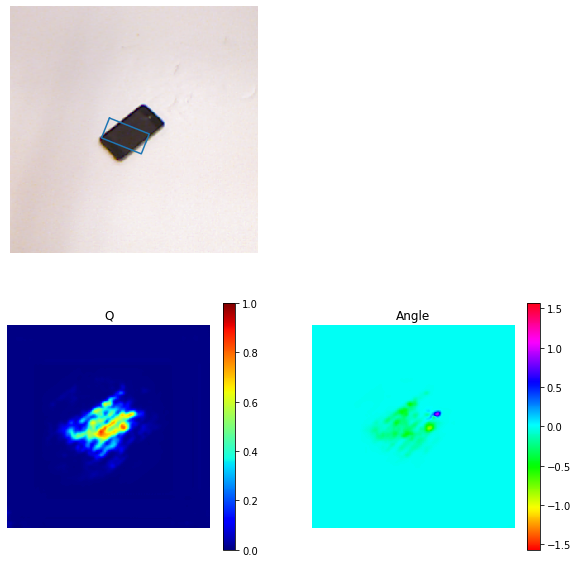

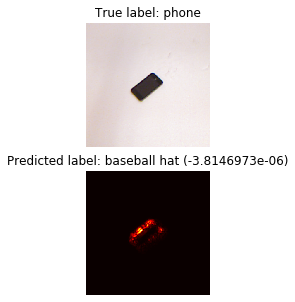

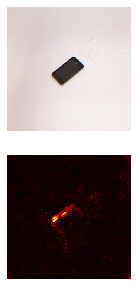

In [31]:
i = 10
show_saliency_maps(images[i], classes[i], grasps[i], retrain2)
show(images[i], classes[i], resnet50)